In [1]:
import matplotlib.pyplot as plt
import cv2
from skimage import filters, measure, transform
from tflearn import DNN
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import fully_connected, input_data, dropout
from tflearn.layers.estimator import regression
from scipy import ndimage as ndi
import numpy as np

plt.set_cmap(plt.gray())

%matplotlib inline

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [9]:
img_fn = '../data/Z3_ICE.jpg'
img = cv2.imread(img_fn, cv2.IMREAD_GRAYSCALE)

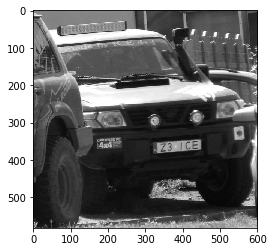

In [10]:
plt.imshow(img)

In [11]:
haar_fn = 'haarcascade_russian_plate_number.xml'
haar = cv2.CascadeClassifier(haar_fn)
detected = haar.detectMultiScale(img)
plates = []
for x, y, w, h in detected:
    obj = img[y:y+h, x:x+w]
    plates.append(obj)

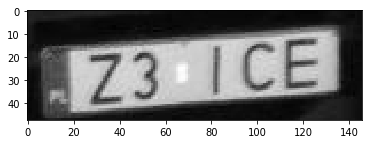

In [12]:
plt.imshow(plates[0])

In [13]:
plate_img = plates[0]
img1 = plate_img < filters.threshold_minimum(plate_img)
img2, _ = ndi.label(img1)
img3 = img2 > 1
contours = measure.find_contours(img3, .1)
letters_positions = []
for i in contours:
    ys, xs = zip(*i)
    x = int(min(xs))
    y = int(min(ys))
    w = int(max(xs) - x + 2)
    h = int(max(ys) - y + 2)
    letter_pos = (x, y, w, h)
    letters_positions.append(letter_pos)

letters_positions = sorted(letters_positions)

letters_img = []
for x, y, w, h in letters_positions:
    letters_img.append(plate_img[y:y+h, x:x+w])

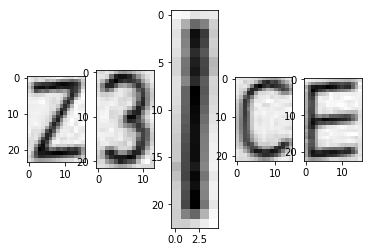

In [14]:
fig, axs = plt.subplots(1, len(letters_img))
for i, v in enumerate(letters_img):
    axs[i].imshow(v)

In [21]:
size = 64

normalized_img = []
for i in letters_img:
    ratio = i.shape[0] / i.shape[1]
    img1 = transform.resize(i, [size, int(size / ratio)], mode='constant')
    width = img1.shape[1]
    missing = (size - width) // 2
    ones = np.ones([size, missing])
    img2 = np.append(ones, img1, 1)
    img3 = np.append(img2, ones, 1)
    if 2 * missing + width != size:
        one = np.ones([size, 1])
        img4 = np.append(img3, one, 1)
    else:
        img4 = img3
    normalized_img.append(img4 * 255)

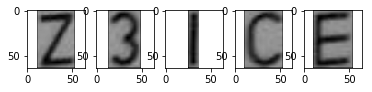

In [16]:
fig, axs = plt.subplots(1, len(normalized_img))
for i, v in enumerate(normalized_img):
    axs[i].imshow(v)

In [17]:
net_input = input_data(shape=[None, 64, 64, 1])

conv1 = conv_2d(net_input, nb_filter=4, filter_size=5, strides=[1, 1, 1, 1], activation='relu')
max_pool1 = max_pool_2d(conv1, kernel_size=2)

conv2 = conv_2d(max_pool1, nb_filter=8, filter_size=5, strides=[1, 2, 2, 1], activation='relu')
max_pool2 = max_pool_2d(conv2, kernel_size=2)

conv3 = conv_2d(max_pool2, nb_filter=12, filter_size=4, strides=[1, 1, 1, 1], activation='relu')
max_pool3 = max_pool_2d(conv3, kernel_size=2)

fc1 = fully_connected(max_pool3, n_units=200, activation='relu')
drop1 = dropout(fc1, keep_prob=.5)

fc2 = fully_connected(drop1, n_units=36, activation='softmax')
net = regression(fc2)

In [18]:
model = DNN(network=net)
model.load(model_file='../data/model/model_weights')

INFO:tensorflow:Restoring parameters from /home/matbur/PycharmProjects/cypsio-pro/data/model/model_weights


In [19]:
labels = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

predicted = []
for i in normalized_img:
    y = model.predict(i.reshape([1, 64, 64, 1]))
    y_pred = np.argmax(y[0])
    predicted.append(labels[y_pred])

In [20]:
predicted

['Z', '3', 'I', 'C', 'E']